In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
df = pd.read_csv('Datasets/PTEN_MCF10A_predictions_ref_set_multi_copy.csv',
                index_col=False)
print(df.head(12))

   variant  MCF10A score  CADD  SNAP2  PolyPhen  SIFT  WT_RSA (%)  \
0      K6E        0.3311  26.6     67     0.155  0.99         NaN   
1      K6I        0.4544  27.3     64     0.244  1.00         NaN   
2     R15S        0.3870  25.0     65     0.123  1.00        53.3   
3     M35V        0.3606  25.0     44     0.914  1.00         0.0   
4     P38H        0.3521  26.1     44     1.000  1.00         0.0   
5     G44D        0.6232  26.0     65     0.968  1.00       117.5   
6     A79T        0.5711  23.0    -95     0.005  0.41        86.3   
7     D92N        0.2677  28.8     90     1.000  1.00        44.3   
8     H93Q        0.3301  26.1     77     1.000  1.00        74.5   
9     H93R        0.3930  27.0     83     0.998  0.97        74.5   
10   I101F        0.8803  26.0      6     0.998  1.00         0.2   
11   I101T        0.7138  29.0     44     0.998  1.00         0.2   

    WT_DEPTH (_)  WT_OSP  MT_RSA (%)  MT_DEPTH (_)  MT_OSP  ground truth  
0            NaN     NaN   

In [3]:
df = df.dropna().reset_index(drop=True)
print(df)

   variant  MCF10A score  CADD  SNAP2  PolyPhen  SIFT  WT_RSA (%)  \
0     A79T        0.5711  23.0    -95     0.005  0.41        86.3   
1    N117S        0.4916  21.0    -92     0.096  0.27        25.3   
2    H123Q        0.9934  25.0     82     0.998  0.98         0.0   
3    H123Y        0.6383  25.0     80     0.996  1.00         0.0   
4    C124S        0.8797  27.3     83     1.000  1.00         4.3   
5    C124R        0.6986  28.0     98     0.999  1.00         4.3   
6    A126D        0.5325  28.2     76     1.000  1.00        55.7   
7    G127R        0.9753  29.0     91     1.000  1.00         0.0   
8    G129R        0.8214  29.0     92     1.000  1.00        18.3   
9    G129E        0.8841  32.0     95     1.000  1.00        18.3   
10   R130Q        0.5361  34.0     96     0.998  0.98         3.1   
11   R130P        0.9134  34.0     93     0.999  1.00         3.1   
12   R130L        0.4728  34.0     92     0.999  1.00         3.1   
13   T131I        0.4788  26.0    

In [4]:
# Binarize the output
from sklearn.preprocessing import label_binarize

y = label_binarize(df['ground truth'], classes=[0, 1, 2])
n_classes = y.shape[1]

In [5]:
X = df.iloc[:, 7:-1]
X_MCF10A = X.assign(MCF10A=df['MCF10A score'])
X_CADD = X.assign(CADD=df['CADD'])
X_SNAP2 = X.assign(SNAP2=df['SNAP2'])
X_SIFT = X.assign(SIFT=df['SIFT'])
X_PolyPhen = X.assign(PolyPhen=df['PolyPhen'])

In [6]:
print(X_MCF10A)

    WT_DEPTH (_)  WT_OSP  MT_RSA (%)  MT_DEPTH (_)  MT_OSP  MCF10A
0            3.1    0.19        80.2           3.2    0.19  0.5711
1            4.0    0.51        10.1           4.0    0.53  0.4916
2           11.0    0.60         0.0          11.4    0.64  0.9934
3           11.0    0.60         0.0          12.1    0.58  0.6383
4            6.7    0.52         4.3           7.3    0.54  0.8797
5            6.7    0.52         8.1           5.8    0.48  0.6986
6            3.1    0.23        68.7           3.5    0.21  0.5325
7            5.2    0.49         0.0           8.3    0.74  0.9753
8            6.1    0.44        23.3           4.7    0.37  0.8214
9            6.1    0.44         4.5           7.3    0.61  0.8841
10           6.5    0.49        11.6           6.8    0.49  0.5361
11           6.5    0.49        15.6           6.3    0.44  0.9134
12           6.5    0.49         8.0           6.9    0.47  0.4728
13           9.1    0.59         0.0           9.1    0.64  0.

# using simple classification

In [7]:
# Learn to predict each class against the other
# using Support Vector Classification, kernal type is linear

def classification(dset):
    X_train, X_test, y_train, y_test = train_test_split(
                            dset, y, test_size=0.33,
                                            random_state=0)
    
    classifier = OneVsRestClassifier(svm.SVC(kernel='linear', 
                                         probability=True, random_state=0))
    
    y_score = classifier.fit(X_train, y_train).decision_function(
                                                    X_test)
    return y_score, y_test

In [8]:
# Compute micro-average ROC curve and area
def miu_avg_roc(test, score):
    fpr, tpr, _ = roc_curve(test.ravel(), score.ravel())
    # .ravel() returns a contiguous flattened array
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

In [9]:
def plot_roc(fpr, tpr, roc_auc, name):
    plt.plot(fpr, tpr, label='AUC for {0} is {1:0.3f}'.format(name, roc_auc))
    plt.plot([0,1], [0,1], color='navy', linestyle='--')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
#    plt.xlim([0.0, 1.0])
#    plt.ylim([0.0, 1.05])
#    plt.title('micro-avg ROC curves')
    plt.legend(loc="lower right")

In [10]:
y_score_MCF10A, y_test = classification(X_MCF10A)
fpr_MCF10A, tpr_MCF10A, roc_auc_MCF10A = miu_avg_roc(y_test, y_score_MCF10A)

In [11]:
print(y_score_MCF10A)
print('\n', y_test)

[[-1.71602587 -0.82642106  0.61914366]
 [-1.66004299 -0.74496142  0.25188996]
 [ 0.29198662 -0.77767726 -2.58442396]
 [-0.24652636  0.56080859 -0.94774179]
 [ 0.96839954 -0.54886044 -3.55512062]
 [-2.34103447 -1.85145074  1.75898232]
 [-0.97689676 -0.00726119 -0.37236216]
 [-0.7421661  -1.24596644 -0.75997125]]

 [[0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]]


In [12]:
print(fpr_MCF10A, '\n', tpr_MCF10A)

[0.     0.0625 0.0625 0.125  0.125  0.3125 0.3125 0.8125 0.8125 1.    ] 
 [0.    0.    0.5   0.5   0.625 0.625 0.875 0.875 1.    1.   ]


In [13]:
y_score_CADD, y_test = classification(X_CADD)
fpr_CADD, tpr_CADD, roc_auc_CADD = miu_avg_roc(y_test, y_score_CADD)

In [14]:
y_score_SNAP2, y_test = classification(X_SNAP2)
fpr_SNAP2, tpr_SNAP2, roc_auc_SNAP2 = miu_avg_roc(y_test, y_score_SNAP2)

In [15]:
y_score_SIFT, y_test = classification(X_SIFT)
fpr_SIFT, tpr_SIFT, roc_auc_SIFT = miu_avg_roc(y_test, y_score_SIFT)

In [16]:
y_score_PolyPhen, y_test = classification(X_PolyPhen)
fpr_PolyPhen, tpr_PolyPhen, roc_auc_PolyPhen = miu_avg_roc(y_test, y_score_PolyPhen)

In [17]:
y_score_baseline, y_test = classification(X)
fpr_baseline, tpr_baseline, roc_auc_baseline = miu_avg_roc(y_test, y_score_baseline)

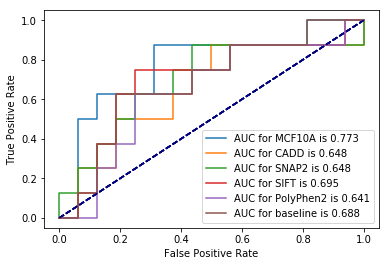

In [18]:
plt.figure()
plot_roc(fpr_MCF10A, tpr_MCF10A, roc_auc_MCF10A, 'MCF10A')
plot_roc(fpr_CADD, tpr_CADD, roc_auc_CADD, 'CADD')
plot_roc(fpr_SNAP2, tpr_SNAP2, roc_auc_CADD, 'SNAP2')
plot_roc(fpr_SIFT, tpr_SIFT, roc_auc_SIFT, 'SIFT')
plot_roc(fpr_PolyPhen, tpr_PolyPhen, roc_auc_PolyPhen, 'PolyPhen2')
plot_roc(fpr_baseline, tpr_baseline, roc_auc_baseline, 'baseline')

mpl.rcParams['pdf.fonttype'] = 42
plt.savefig('Output PDFs/micro-avg roc.pdf', transparent=True, dpi=200)

plt.show()

In [19]:
# calculate macro-average roc
def mac_avg_roc(y_test, y_score):
    from scipy import interp
    
    # first ompute ROC curves and ROC areas for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at these points    
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC        
    mean_tpr /= n_classes
    
    fpr_macro = np.insert(all_fpr, 0, 0)
    tpr_macro = np.insert(mean_tpr, 0, 0)
    
    return fpr_macro, tpr_macro

In [20]:
fpr_MCF10A_macro, tpr_MCF10A_macro = mac_avg_roc(y_test, y_score_MCF10A)
roc_auc_macro_MCF10A = auc(fpr_MCF10A_macro, tpr_MCF10A_macro)

In [21]:
print(fpr_MCF10A_macro, '\n')
print(tpr_MCF10A_macro)

[0.         0.         0.14285714 0.2        0.25       1.        ] 

[0.         0.38888889 0.72222222 0.83333333 0.91666667 1.        ]


In [22]:
all_fpr_CADD, mean_tpr_CADD = mac_avg_roc(y_test, y_score_CADD)
roc_auc_macro_CADD = auc(all_fpr_CADD, mean_tpr_CADD)

In [23]:
all_fpr_SNAP2, mean_tpr_SNAP2 = mac_avg_roc(y_test, y_score_SNAP2)
roc_auc_macro_SNAP2 = auc(all_fpr_SNAP2, mean_tpr_SNAP2)

In [24]:
all_fpr_SIFT, mean_tpr_SIFT = mac_avg_roc(y_test, y_score_SIFT)
roc_auc_macro_SIFT = auc(all_fpr_SIFT, mean_tpr_SIFT)

In [25]:
all_fpr_PolyPhen, mean_tpr_PolyPhen = mac_avg_roc(y_test, y_score_PolyPhen)
roc_auc_macro_PolyPhen = auc(all_fpr_PolyPhen, mean_tpr_PolyPhen)

In [26]:
fpr_baseline_macro, tpr_baseline_macro = mac_avg_roc(y_test, y_score_baseline)
roc_auc_macro_baseline = auc(fpr_baseline_macro, fpr_baseline_macro)

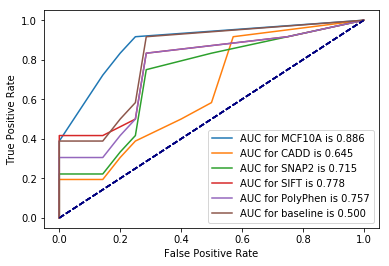

In [27]:
plt.figure()
plot_roc(fpr_MCF10A_macro, tpr_MCF10A_macro, roc_auc_macro_MCF10A, 'MCF10A')
plot_roc(all_fpr_CADD, mean_tpr_CADD, roc_auc_macro_CADD, 'CADD')
plot_roc(all_fpr_SNAP2, mean_tpr_SNAP2, roc_auc_macro_SNAP2, 'SNAP2')
plot_roc(all_fpr_SIFT, mean_tpr_SIFT, roc_auc_macro_SIFT, 'SIFT')
plot_roc(all_fpr_PolyPhen, mean_tpr_PolyPhen, roc_auc_macro_PolyPhen, 'PolyPhen')
plot_roc(fpr_baseline_macro, tpr_baseline_macro, roc_auc_macro_baseline, 'baseline')

mpl.rcParams['pdf.fonttype'] = 42
plt.savefig('Output PDFs/macro-avg roc multi.pdf', transparent=True, dpi=200)

plt.show()

In [38]:
print(y)

[[0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]]


# experimental codes

In [24]:
# either run this classifier (SVC)

In [25]:
# Learn to predict each class against the other
# using C-Support Vector Classification, kernal type is linear
from sklearn import svm

X_train_MCF10A, X_test_MCF10A, y_train, y_test = train_test_split(
    X_MCF10A, y, test_size=.33, random_state=0)

classifier = OneVsRestClassifier(svm.SVC(kernel='linear', 
                                         probability=True, random_state=0))

y_score_MCF10A = classifier.fit(X_train_MCF10A, y_train).decision_function(X_test_MCF10A)
#y_score_CADD = classifier.decision_function(X_CADD)

In [26]:
# or run this one (Decision Tree)

In [27]:
# Learn to predict each class against the other
# using Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier

classifier = OneVsRestClassifier(DecisionTreeClassifier(random_state=0))

y_score_MCF10A = classifier.fit(X_train_MCF10A, y_train).predict_proba(X_test_MCF10A)

In [28]:
# Compute micro-average ROC curve and area
fpr_MCF10A, tpr_MCF10A, _ = roc_curve(y_test.ravel(), y_score_MCF10A.ravel())
roc_auc_MCF10A = auc(fpr_MCF10A, tpr_MCF10A)

#fpr_CADD, tpr_CADD, _ = roc_curve(y_test.ravel(), y_score_CADD.ravel())
#roc_auc_CADD = auc(fpr_CADD, tpr_CADD)

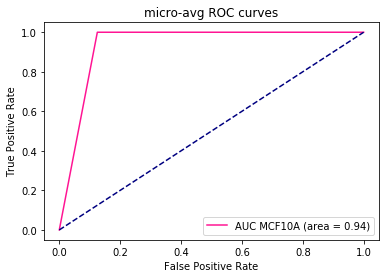

In [29]:
fig, ax = plt.subplots()

ax.plot(fpr_MCF10A, tpr_MCF10A,
         label='AUC MCF10A (area = {0:0.2f})'.format(roc_auc_MCF10A),
         color='deeppink')
#ax.plot(fpr_CADD, tpr_CADD,
#         label='AUC CADD (area = {0:0.2f})'.format(roc_auc_CADD),
#         color='orange')

ax.plot([0, 1], [0, 1], color='navy', linestyle='--')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('micro-avg ROC curves')
legend = ax.legend(loc="lower right")

plt.show()

# exercise using the ex from scikit-learn

In [30]:
# shuffle and split training and test sets

X_train_MCF10A, X_test_MCF10A, y_train, y_test = train_test_split(
    X_MCF10A, y, test_size=.33)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,))

y_score_MCF10A = classifier.fit(X_train_MCF10A, y_train).decision_function(X_test_MCF10A)

In [31]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_MCF10A[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [32]:
print(fpr[0])
print(fpr[1])
print(fpr[2])

[0.         0.16666667 0.16666667 1.        ]
[0.  0.  0.2 0.2 0.6 0.6 1. ]
[0. 0. 0. 1. 1.]


In [33]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score_MCF10A.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [34]:
# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [35]:
all_fpr

array([0.        , 0.16666667, 0.2       , 0.6       , 1.        ])

In [36]:
# Then interpolate all ROC curves at these points
from scipy import interp

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) #'+=' is i_add. a=2. a+=3 returns 5.

# Finally average it and compute AUC
mean_tpr /= n_classes

In [37]:
type(mean_tpr)
print('all_fpr: ', all_fpr, '\n')
print('mean_tpr', mean_tpr)

all_fpr:  [0.         0.16666667 0.2        0.6        1.        ] 

mean_tpr [0.33333333 0.66666667 0.77777778 0.88888889 1.        ]


In [38]:
fpr["macro"] = np.insert(all_fpr, 0, 0)
tpr["macro"] = np.insert(mean_tpr, 0, 0)
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

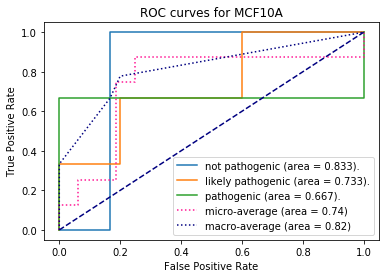

In [41]:
# plot all the classes
fig, ax = plt.subplots()

ax.plot(fpr[0], tpr[0],
         label='not pathogenic (area = {0:0.3f}).'.format(roc_auc[0]))
ax.plot(fpr[1], tpr[1],
         label='likely pathogenic (area = {0:0.3f}).'.format(roc_auc[1]))
ax.plot(fpr[2], tpr[2],
         label='pathogenic (area = {0:0.3f}).'.format(roc_auc[2]))
ax.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':')
ax.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':')

ax.plot([0, 1], [0, 1], color='navy', linestyle='--')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curves for MCF10A')
legend = ax.legend(loc="lower right")

plt.show()

# trying cross-validation

In [40]:
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=0)